In [ ]:

import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time
import copy
from sklearn import metrics
import seaborn as sns
from torchvision.models import resnet50
from os.path import exists
import pandas as pd
import warnings
from sklearn.svm import SVC
import numpy as np
#from tpot import TPOTClassifier
from sklearn.metrics import confusion_matrix as confusion
warnings.filterwarnings('ignore')
sns.set()

In [ ]:
if not exists('data'):
    !wget -O boat-data.zip https://artist-cloud.ecs.soton.ac.uk/index.php/s/eAhIkhhdxgmhRHj/download
    !unzip boat-data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/train/Water/20130307_132914_88100.jpg  
  inflating: __MACOSX/data/train/Water/._20130307_132914_88100.jpg  
  inflating: data/train/Water/20130307_094447_52382.jpg  
  inflating: __MACOSX/data/train/Water/._20130307_094447_52382.jpg  
  inflating: data/train/Water/20130306_130050_70834.jpg  
  inflating: __MACOSX/data/train/Water/._20130306_130050_70834.jpg  
  inflating: data/train/Water/20130307_153426_05218.jpg  
  inflating: __MACOSX/data/train/Water/._20130307_153426_05218.jpg  
  inflating: data/train/Water/20130305_143831_94019.jpg  
  inflating: __MACOSX/data/train/Water/._20130305_143831_94019.jpg  
  inflating: data/train/Water/20130305_130423_80505.jpg  
  inflating: __MACOSX/data/train/Water/._20130305_130423_80505.jpg  
  inflating: data/train/Water/20130304_125717_21597.jpg  
  inflating: __MACOSX/data/train/Water/._20130304_125717_21597.jpg  
  inflating: data/train/Water/20130305_131821_81936.jpg  
  

In [ ]:
def confusion_matrix(data, nb_classes, name):
    df_cm = pd.DataFrame(data, 
                          range(nb_classes), range(nb_classes))
    plt.figure(figsize=(10,7))
    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', 
                fmt='g')
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel("Predicted Output", fontsize = 18)
    plt.ylabel("Expected Output", fontsize = 18)
    plt.savefig(str(name) + "_confusion_matrix.png", format='png', dpi=1200)
    plt.show()

In [ ]:
def acc_per_class(model, testloader, nb_classes, name):
      model.eval()
      confusion_mat = torch.zeros(nb_classes, nb_classes)
      for inputs, labels in testloader:
          outputs = model(inputs.cuda())
          _, preds = torch.max(outputs, 1)
          for t, p in zip(labels.view(-1), preds.view(-1)):
                  confusion_mat[t.long(), p.long()] += 1

      confusion_matrix(confusion_mat.data.cpu().numpy(), nb_classes, name)

      per_class_acc = 100*confusion_mat.diag()/confusion_mat.sum(1)
      for i, j in enumerate(per_class_acc.data.cpu().numpy()):
        print("Class:", i, "Accuracy:", j)
      acc = torch.mean(per_class_acc).data.cpu().numpy()
      print("Average Accuracy: ", acc, "%")
      print("Overall Accuracy: ", 
            (100*sum(confusion_mat.diag())/confusion_mat.sum()).numpy(), "%")

In [ ]:
def train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot, name):
    print("Final training loss: ", loss_plot[len(loss_plot)-1])
    print("Final validation loss: ", val_loss_plot[len(val_loss_plot)-1])
    print("Final training accuracy: ", acc_plot[len(acc_plot)-1])
    print("Final validation accuracy: ", val_acc_plot[len(val_acc_plot)-1])
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    #plt.tight_layout()
    ax[0].plot(loss_plot, label="Training Loss")
    ax[0].plot(val_loss_plot, label="Validation Loss")
    ax[0].legend(fontsize=18)
    ax[0].grid(True)
    ax[0].set_ylim(bottom=0)
    ax[0].set_title(name + " Training/Validation Loss", fontsize=20);
    ax[0].set_xlabel("Epoch", fontsize=18);
    ax[0].set_ylabel("Loss", fontsize=18);
    ax[1].plot(acc_plot, label="Training Accuracy")
    ax[1].plot(val_acc_plot, label="Validation Accuracy")
    ax[1].legend(fontsize=18)
    ax[1].grid(True)
    ax[1].set_ylim(bottom=0)
    ax[1].set_title(name + " Training/Validation Accuracy", fontsize=20);
    ax[1].set_xlabel("Epoch", fontsize=18);
    ax[1].set_ylabel("Accuracy", fontsize=18);
    plt.savefig(name + "_Training.png", format='png', dpi=1200)
    plt.show()

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, name):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_plot= []
    val_loss_plot = []
    acc_plot= []
    val_acc_plot = []
    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # Next two lines enable us to use Binary Crossentropy
                    #outputs = outputs.squeeze(1)
                    #loss = criterion(outputs, labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                loss_plot.append(epoch_loss)
                acc_plot.append(epoch_acc)
            else:
                val_loss_plot.append(epoch_loss)
                val_acc_plot.append(epoch_acc)

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, 
            #                                            epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val accuracy: {:4f}'.format(best_acc))

    # loading best model weights
    model.load_state_dict(best_model_wts)
    train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot, name)
    return model

A simple CNN for boat classification

In [ ]:
# Model Definition
class BetterCNN(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(BetterCNN, self).__init__()
        self.conv1 = nn.Conv2d(n_channels_in, 30, (5, 5), padding=0)
        self.conv2 = nn.Conv2d(30, 15, (3, 3), padding=0)
        self.fc1 = nn.Linear(1725, 128)
        self.fc2 = nn.Linear(128, 50)
        self.fc3 = nn.Linear(50, n_classes)
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        out = F.dropout(out, 0.2, training=self.training)
        out = out.view(out.shape[0], -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [ ]:
# the number of images that will be processed in a single step
batch_size=128
# the size of the images that we'll learn on - we'll shrink them from the original size for speed
image_size=(30, 100)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()  # convert to tensor
])

train_dataset = ImageFolder("data/train", transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder("data/valid", transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder("data/test", transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training complete in 2m 30s
Best val accuracy: 0.721519
Final training loss:  0.84281983885809
Final validation loss:  0.9197015145840712
Final training accuracy:  tensor(0.7429, device='cuda:0', dtype=torch.float64)
Final validation accuracy:  tensor(0.7215, device='cuda:0', dtype=torch.float64)


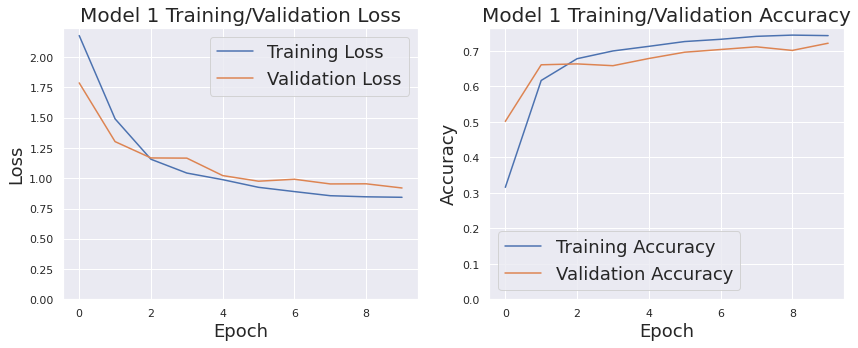

BetterCNN(
  (conv1): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(30, 15, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1725, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=16, bias=True)
)

In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# build the model
model = BetterCNN(3, len(train_dataset.classes))
if torch.cuda.is_available():
    model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model.parameters())
train_model(model, criterion, optimizer_ft, num_epochs=10, name="Model 1")

In [ ]:
def test_model(model, testloader):
    model.eval()
    if torch.cuda.is_available():
        model.cuda()
    running_loss = 0.0
    corrects = 0.0
    preds_list = []
    for x, y in testloader:
        x, y = x.cuda(), y.cuda()
        outputs = model(x)
        _, preds = torch.max(outputs, 1)
        preds_list.extend(preds)
        loss = criterion(outputs, y)
        # statistics
        running_loss += loss.item() * x.size(0)
        corrects += torch.sum(preds == y)

    overall_loss = running_loss / len(testloader.dataset)
    overall_acc = corrects.double() / len(testloader.dataset)
    print('Test Loss: %2.2f' % overall_loss)
    print('Test Accuracy: %2.2f' % overall_acc)
    true_classes = list(x for (_,x) in test_dataset.samples)
    preds_res = [i.cpu().detach().numpy() for i in preds_list]
    print(metrics.classification_report(true_classes, preds_res, target_names=train_dataset.classes))
test_model(model, test_loader)

Test Loss: 0.78
Test Accuracy: 0.77
                         precision    recall  f1-score   support

              Alilaguna       0.48      0.74      0.58        19
              Ambulanza       0.11      0.09      0.10        22
               Barchino       0.00      0.00      0.00        51
                Gondola       0.00      0.00      0.00         3
          Lanciafino10m       0.00      0.00      0.00         7
              Motobarca       0.00      0.00      0.00        59
Motopontonerettangolare       0.00      0.00      0.00         3
          MotoscafoACTV       0.00      0.00      0.00         1
               Mototopo       0.60      0.91      0.73       274
              Patanella       0.34      0.55      0.42        74
                Polizia       0.00      0.00      0.00        15
        Raccoltarifiuti       0.00      0.00      0.00        19
           Sandoloaremi       0.00      0.00      0.00         3
                   Topa       0.00      0.00      0.0

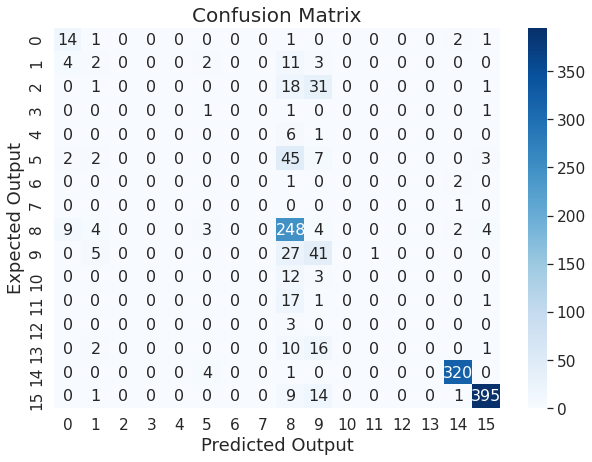

Class: 0 Accuracy: 73.68421
Class: 1 Accuracy: 9.090909
Class: 2 Accuracy: 0.0
Class: 3 Accuracy: 0.0
Class: 4 Accuracy: 0.0
Class: 5 Accuracy: 0.0
Class: 6 Accuracy: 0.0
Class: 7 Accuracy: 0.0
Class: 8 Accuracy: 90.51095
Class: 9 Accuracy: 55.405407
Class: 10 Accuracy: 0.0
Class: 11 Accuracy: 0.0
Class: 12 Accuracy: 0.0
Class: 13 Accuracy: 0.0
Class: 14 Accuracy: 98.46154
Class: 15 Accuracy: 94.04762
Average Accuracy:  26.325039 %
Overall Accuracy:  77.039276 %


In [ ]:
acc_per_class(model, test_loader, len(train_dataset.classes), name='Model 1')

Using a better network model - transferring and finetuning a pretrained ResNet¶


In [ ]:
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
model.fc = nn.Linear(2048, len(train_dataset.classes))
model.train()
# Freeze layers by not tracking gradients
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True #unfreeze last layer weights
model.fc.bias.requires_grad = True #unfreeze last layer biases
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=1e-4) #only optimse non-frozen layers

In [ ]:
res = train_model(model, criterion, optimizer_ft, num_epochs=10, 
                    name="FineTuning")

RuntimeError: ignored

In [ ]:
test_model(model, test_loader)

In [ ]:

acc_per_class(model, test_loader, len(train_dataset.classes), name='Finetuned')

Optimise

In [ ]:
dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Increased learning rate
model = resnet50(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
model.fc = nn.Linear(2048, len(train_dataset.classes))
model.train()
# Freeze layers by not tracking gradients
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True #unfreeze last layer weights
model.fc.bias.requires_grad = True #unfreeze last layer biases
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=5e-4) #only optimse non-frozen layers

res = train_model(model, criterion, optimizer_ft, num_epochs=10, 
                    name="Increased LR")

test_model(model, test_loader)
acc_per_class(model, test_loader, len(train_dataset.classes), 
              name='Increased LR')

In [ ]:
# Increased number of epochs
model = resnet50(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
model.fc = nn.Linear(2048, len(train_dataset.classes))
model.train()
# Freeze layers by not tracking gradients
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True #unfreeze last layer weights
model.fc.bias.requires_grad = True #unfreeze last layer biases
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=1e-4) #only optimse non-frozen layers

res = train_model(model, criterion, optimizer_ft, num_epochs=20, 
                    name="Increased LR")

test_model(model, test_loader)
acc_per_class(model, test_loader, len(train_dataset.classes), 
              name='Increased LR')

Improving Image Preprocessing


In [ ]:
preprocess_input = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


train_dataset = ImageFolder("data/train", preprocess_input)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder("data/valid", preprocess_input)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder("data/test", preprocess_input)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = resnet50(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
model.fc = nn.Linear(2048, len(train_dataset.classes))
model.train()
# Freeze layers by not tracking gradients
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True #unfreeze last layer weights
model.fc.bias.requires_grad = True #unfreeze last layer biases
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=7e-4) #only optimse non-frozen layers

res = train_model(model, criterion, optimizer_ft, num_epochs=20, 
                    name="Image Processing")

test_model(model, test_loader)

In [ ]:
acc_per_class(model, test_loader, len(train_dataset.classes), 
              name='Increased LR')

Data Augmentation


In [ ]:
transform = transforms.Compose([
      transforms.RandomRotation(30),
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

preprocess_input = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


train_dataset = ImageFolder("data/train", transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageFolder("data/valid", preprocess_input)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageFolder("data/test", preprocess_input)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_loader.dataset), 'val': len(val_loader.dataset)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = resnet50(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d((1,1))
model.fc = nn.Linear(2048, len(train_dataset.classes))
model.train()
# Freeze layers by not tracking gradients
for param in model.parameters():
    param.requires_grad = False
model.fc.weight.requires_grad = True #unfreeze last layer weights
model.fc.bias.requires_grad = True #unfreeze last layer biases
if torch.cuda.is_available():
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                          lr=1e-3) #only optimse non-frozen layers

res = train_model(model, criterion, optimizer_ft, num_epochs=75, 
                    name="")

test_model(model, test_loader)

In [ ]:
acc_per_class(model, test_loader, len(train_dataset.classes), 
              name='')

Extracting features from a model¶


In [ ]:
if not exists('training_features.npy'):
    !wget -O Resnet50Features.zip https://artist-cloud.ecs.soton.ac.uk/index.php/s/P68OB07DquOwSR7/download
    !unzip Resnet50Features.zip

training_features = np.load('training_features.npy')
training_labels = np.load('training_labels.npy')

valid_features = np.load('valid_features.npy')
valid_labels = np.load('valid_labels.npy')

testing_features = np.load('testing_features.npy')
testing_labels = np.load('testing_labels.npy')

In [ ]:
clf = SVC()
clf.fit(training_features, training_labels)
print(clf.score(valid_features, valid_labels))
predictions = clf.predict(testing_features)
print(metrics.classification_report(testing_labels, predictions, target_names=train_dataset.classes))

In [ ]:
parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
              'C': list(np.linspace(0.01, 2, 10, dtype = float))}
               
tpot_classifier = TPOTClassifier(generations= 3, population_size= 5, offspring_size= 3,
                                 verbosity= 2, early_stop= 12,
                                 config_dict= {'sklearn.svm.SVC': parameters}, 
                                 cv = 4, scoring = 'accuracy')
tpot_classifier.fit(training_features, training_labels)

In [ ]:
print("Validation Accuracy: ", tpot_classifier.score(valid_features, valid_labels))
print("Testing Accuracy: ", tpot_classifier.score(testing_features, testing_labels))

In [ ]:
tpot_classifier.fitted_pipeline_

In [ ]:
nb_classes = 16
df_cm = pd.DataFrame(confusion(testing_labels, predictions), 
                      range(nb_classes), range(nb_classes))
plt.figure(figsize=(10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},cmap='Blues', 
            fmt='g')
plt.title("Confusion Matrix", fontsize = 20)
plt.xlabel("Predicted Output", fontsize = 18)
plt.ylabel("Expected Output", fontsize = 18)
plt.savefig("SVM_confusion_matrix.png", format='png', dpi=1200)
plt.show()